In [1613]:
from collections import defaultdict
from itertools import product

import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

### Часть первая, с блекджеком и стратегиями

##### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

В силу тривиальности нашей стратегии в качестве состояния будем рассматривать лишь сумму карт в нашей руке - единственный параметр, по которому принимается решение о выборе действия.

In [1201]:
def pi(state):
    if state <= 18:
        return True  # hit
    else:
        return False  # stand

In [1098]:
def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21

def sum_hand(hand):
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)

In [1202]:
def run_episode(env, pi):
    env.reset()
    states, rewards = [sum_hand(env.player)], [0.]
    done = False
    while not done:
        observation, reward, done, info = env.step(pi(states[-1]))
        players_sum, dealers_card, ace_is_usable = observation
        states.append(players_sum)
        rewards.append(reward)
    return states, rewards

def update_returns(returns, states, rewards, gamma):
    G = 0
    for t in range(len(states) - 2, -1, -1):
        G = gamma*G + rewards[t+1]
        returns[states[t]].append(G)

Алгоритм для нахождения функции $V_\pi$, оценивающей нашу стратегию $\pi$. При этом не будем отдельно описывать все возможное пространство состояний, т.к. за счет встроенной в нашу среду случайности по раздаче карт при большом количестве эпизодов мы действительно посетим все возможные состояния.

In [1101]:
def monte_carlo_estim(env, pi, gamma, n_of_episodes):
    V = {}
    returns = defaultdict(list)
    for episode in range(n_of_episodes):
        states, rewards = run_episode(env, pi)
        update_returns(returns, states, rewards, gamma)
    for state, rtrns in returns.items():
        V[state] = np.mean(rtrns)
    return V

In [1203]:
def average_payoff(env, pi, n_of_episodes):
    total_payoff = 0
    for episode in range(n_of_episodes):
        episode_payoff = run_episode(env, pi)[-1][-1]
        total_payoff += episode_payoff
    return total_payoff / n_of_episodes

In [1204]:
env = gym.make('Blackjack-v0', natural=True)
n_of_episodes = 100000
gamma = 1

V_pi = monte_carlo_estim(env, pi, gamma, n_of_episodes)
avg_payoff_pi = average_payoff(env, pi, n_of_episodes)

env.close()

Получившаяся функция $V_\pi$:

In [1097]:
sorted(V_pi.items())

[(4, -0.3600713012477718),
 (5, -0.40703517587939697),
 (6, -0.38326954620010933),
 (7, -0.40682846565199504),
 (8, -0.43087697929354446),
 (9, -0.14840989399293286),
 (10, -0.028595458368376788),
 (11, 0.04709897610921502),
 (12, -0.40148339245404707),
 (13, -0.4408981676179033),
 (14, -0.46565707313572097),
 (15, -0.5013723696248856),
 (16, -0.5298699539420212),
 (17, -0.581791945428309),
 (18, -0.580735284779986),
 (19, 0.2780990696504903),
 (20, 0.580437643159998),
 (21, 1.0238924158645641)]

Также, пример функции $V_\pi$, когда в качестве состояния мы в том числе рассматриваем информацию, содержится ли у нас на руках *usable ace*. (Здесь, например, можно заметить, что играем именно в *natural Blackjack*).

In [519]:
sorted(V_pi.items())

[((4, False), -0.28833333333333333),
 ((5, False), -0.33414634146341465),
 ((6, False), -0.3941208492106696),
 ((7, False), -0.408812729498164),
 ((8, False), -0.4051939924906133),
 ((9, False), -0.15943466402182),
 ((10, False), -0.04333470903838217),
 ((11, False), 0.04587470044505306),
 ((12, False), -0.44099165016785746),
 ((12, True), -0.10981697171381032),
 ((13, False), -0.4711872826626925),
 ((13, True), -0.09662215239591516),
 ((14, False), -0.5164817623114375),
 ((14, True), -0.1613899613899614),
 ((15, False), -0.5403200745804848),
 ((15, True), -0.24388631857237278),
 ((16, False), -0.5813546423135464),
 ((16, True), -0.24297314178638352),
 ((17, False), -0.6068036227081953),
 ((17, True), -0.26914660831509846),
 ((18, False), -0.6360636924401091),
 ((18, True), -0.323400097703957),
 ((19, False), 0.2768748633481525),
 ((19, True), 0.2548928238583411),
 ((20, False), 0.5745438362260792),
 ((20, True), 0.5740498034076016),
 ((21, False), 0.885419032477856),
 ((21, True), 1.2

Оценка выигрыша стратегии $\pi$:

In [1106]:
print(f'Таким образом на {n_of_episodes} раздачах получаем по нашей стратегии средний выигрыш {avg_payoff_pi}')

Таким образом на 100000 раздачах получаем по нашей стратегии средний выигрыш -0.17942


##### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [1182]:
'''
# Построим пространство состояний явным образом
observation_space = list(product(range(4, 21 + 1), range(1, 10 + 1), (False, True)))
observation_space = [obs for obs in observation_space if obs[0] > 11 or not obs[2]]

def get_random_Q(env, obsrvtn_space):
    # Q = np.zeros((len(obsrvtn_space), env.action_space.n))
    Q = {state: np.zeros(env.action_space.n) for state in obsrvtn_space}
    return Q
'''

def compute_policy_by_Q(Q):
    # return np.argmax(Q, axis=1)
    return {state: np.argmax(actions) for state, actions in Q.items()}

In [1702]:
'''
class DefaultDictWKey(defaultdict):
    def __missing__(self, key):
        value = self.default_factory(key)
        self[key] = value
        return value

def compute_policy_by_Q_upd(Q):
    return DefaultDictWKey(lambda state: np.argmax(Q[state]), {state: np.argmax(actions) for state, actions in Q.items()})
'''

In [1654]:
def eps_greedy_pi(env, state, Q, eps):
    if np.random.rand() > eps:
        return np.argmax(Q[state])
    else:
        return env.action_space.sample()

In [1711]:
def run_episode(env, pi, eps=0.):
    observation = env.reset()
    states, actions, rewards = [observation], [], [0.]
    done = False
    while not done:
        action = pi[observation] if np.random.rand() > eps else env.action_space.sample()
        observation, reward, done, info = env.step(action)
        states.append(observation)
        actions.append(action)
        rewards.append(reward)
    return states, actions, rewards

Реализуем алгоритм **Monte Carlo control**

In [1780]:
def run_episode_MC(env, Q, eps=0.):
    observation = env.reset()
    states, actions, rewards = [observation], [], [0.]
    done = False
    while not done:
        action = eps_greedy_pi(env, observation, Q, eps)
        observation, reward, done, info = env.step(action)
        states.append(observation)
        actions.append(action)
        rewards.append(reward)
    return states, actions, rewards

def update(Q, N, gamma, states, actions, rewards):
    G = 0.
    for t in range(len(states) - 2, -1, -1):
        G = gamma*G + rewards[t+1]
        N[states[t]][actions[t]] += 1
        Q[states[t]][actions[t]] += (G-Q[states[t]][actions[t]]) / N[states[t]][actions[t]]

In [1781]:
def monte_carlo_control(env, gamma, n_of_episodes, eps, rec_history=False, estim_epsds=100000, rec_freq=10):
    # Q = get_random_Q(env, observation_space)
    # pi = compute_policy_by_Q(Q)
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # pi = defaultdict(lambda: 0)  # argmax([0,...,0]) == 0
    # pi = compute_policy_by_Q_upd(Q)
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    for episode in range(n_of_episodes):
        states, actions, rewards = run_episode_MC(env, Q, eps)
        update(Q, N, gamma, states, actions, rewards)
        # pi = compute_policy_by_Q_upd(Q)
        if rec_history and (episode+1) % (n_of_episodes//rec_freq) == 0:
            pi = compute_policy_by_Q(Q)
            cur_avg_payoff = average_payoff(env, pi, estim_epsds)
            learning_history_MC.append(cur_avg_payoff)
    return Q

In [1782]:
%%time
env = gym.make('Blackjack-v0', natural=True)
n_of_episodes = 1000000
gamma = 1
eps = 0.1
estim_epsds = 100000
rec_freq = 10

learning_history_MC = []
Q_opt = monte_carlo_control(env, gamma, n_of_episodes, eps, rec_history=True, estim_epsds=estim_epsds, rec_freq=rec_freq)
pi_opt = compute_policy_by_Q(Q_opt)
avg_payoff_opt = average_payoff(env, pi_opt, estim_epsds)

env.close()

Wall time: 2min 41s


Оценка выигрыша стратегии $\pi^*$:

In [1783]:
print(f'Таким образом на {estim_epsds} раздачах получаем по нашей стратегии средний выигрыш {avg_payoff_opt}')

Таким образом на 100000 раздачах получаем по нашей стратегии средний выигрыш -0.03065


Реализуем алгоритм **Q-learning**

In [1698]:
def Q_learning_episode(env, Q, alpha=0.05, eps=0.0, gamma=0.9):
    observation = env.reset()
    action = eps_greedy_pi(env, observation, Q, eps)
    done = False
    while not done:
        next_observation, reward, done, info = env.step(action)
        if not done:
            next_action = eps_greedy_pi(env, next_observation, Q, eps)
            Q[observation][action] += alpha * (reward + gamma*np.max(Q[next_observation]) - Q[observation][action])
            observation, action = next_observation, next_action
        else:
            Q[observation][action] += alpha * (reward-Q[observation][action])

In [1656]:
def Q_learning(env, gamma, n_of_episodes, eps, alpha, rec_history=False, estim_epsds=100000, rec_freq=10):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # pi = compute_policy_by_Q(Q)
    for episode in range(n_of_episodes):
        Q_learning_episode(env, Q, alpha, eps, gamma)
        # pi = compute_policy_by_Q(Q)
        if rec_history and (episode+1) % (n_of_episodes//rec_freq) == 0:
            pi = compute_policy_by_Q_upd(Q)
            cur_avg_payoff = average_payoff(env, pi, estim_epsds)
            learning_history_Q.append(cur_avg_payoff)
    return Q

In [1668]:
%%time
env = gym.make('Blackjack-v0', natural=True)
n_of_episodes = 1000000
gamma = 1
eps = 0.1
alpha = 0.1 # 0.05
estim_epsds = 100000
rec_freq = 10

learning_history_Q = []
Q_opt = Q_learning(env, gamma, n_of_episodes, eps, alpha, rec_history=True, estim_epsds=estim_epsds, rec_freq=rec_freq)
pi_opt = compute_policy_by_Q(Q_opt)
avg_payoff_opt = average_payoff(env, pi_opt, estim_epsds)

env.close()

Wall time: 2min 20s


Оценка выигрыша стратегии $\pi^*$:

In [1670]:
print(f'Таким образом на {estim_epsds} раздачах получаем по нашей стратегии средний выигрыш {avg_payoff_opt}')

Таким образом на 100000 раздачах получаем по нашей стратегии средний выигрыш -0.048635


##### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

Рассмотрим результаты реализации стратегии, обученной **методом Монте-Карло**

In [1787]:
print(f'Средний выигрыш стратегии равен {avg_payoff_opt}')

Средний выигрыш стратегии равен -0.03065


Нарисуем график обучения данной стратегии по среднему доходу

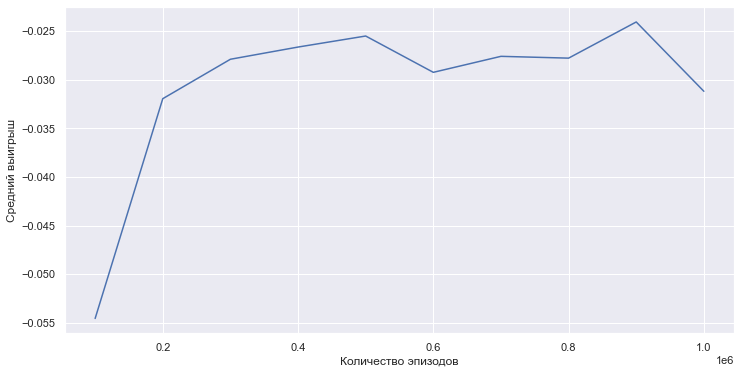

In [1788]:
plt.figure(figsize=(12, 6))
plt.xlabel('Количество эпизодов')
plt.ylabel('Средний выигрыш')
plt.plot(range(n_of_episodes // rec_freq, n_of_episodes + 1, n_of_episodes // rec_freq), learning_history_MC)
plt.show()

Рассмотрим результаты реализации стратегии, обученной **методом Q-обучения**

In [1671]:
print(f'Средний выигрыш стратегии равен {avg_payoff_opt}')

Средний выигрыш стратегии равен -0.048635


Нарисуем график обучения данной стратегии по среднему доходу

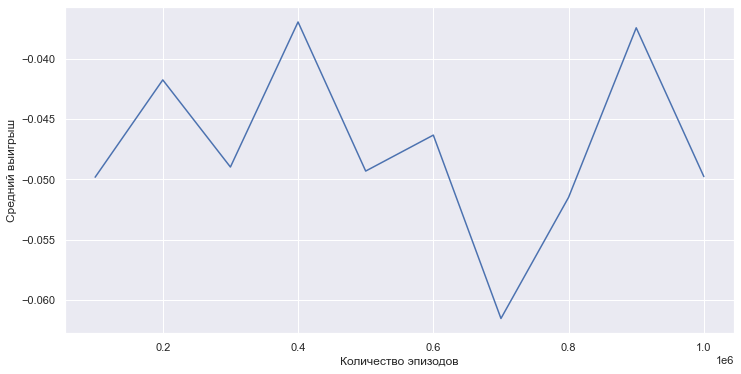

In [1672]:
plt.figure(figsize=(12, 6))
plt.xlabel('Количество эпизодов')
plt.ylabel('Средний выигрыш')
plt.plot(range(n_of_episodes // rec_freq, n_of_episodes + 1, n_of_episodes // rec_freq), learning_history_Q)
plt.show()

### Часть вторая, удвоенная

##### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [1800]:
import gym
from gym import spaces
from gym.utils import seeding

def cmp(a, b):
    return float(a > b) - float(a < b)

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card(np_random):
    return int(np_random.choice(deck))


def draw_hand(np_random):
    return [draw_card(np_random), draw_card(np_random)]


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackDoubleEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2)))
        self.seed()

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick or double
            done = True
            if action == 2:  # double
                self.player.append(draw_card(self.np_random))
                if is_bust(self.player):
                    reward = -2.
                    return self._get_obs(), reward, done, {}
            while sum_hand(self.dealer) < 17:
                self.dealer.append(draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if action == 2:
                reward *= 2
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player))

    def reset(self):
        self.dealer = draw_hand(self.np_random)
        self.player = draw_hand(self.np_random)
        return self._get_obs()

##### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

Рассмотрим результаты реализации стратегии, обученной **методом Монте-Карло**

In [1801]:
env_double = BlackjackDoubleEnv(natural=True)
n_of_episodes = 1000000
gamma = 1
eps = 0.1
estim_epsds = 100000
rec_freq = 10

learning_history_MC = []
Q_opt = monte_carlo_control(env_double, gamma, n_of_episodes, eps, rec_history=True, estim_epsds=estim_epsds, rec_freq=rec_freq)
pi_opt = compute_policy_by_Q(Q_opt)
avg_payoff_opt = average_payoff(env_double, pi_opt, estim_epsds)

env_double.close()

Оценка выигрыша стратегии $\pi^*$:

In [1803]:
print(f'Таким образом на {estim_epsds} раздачах получаем по нашей стратегии средний выигрыш {avg_payoff_opt}')

Таким образом на 100000 раздачах получаем по нашей стратегии средний выигрыш -0.01419


Нарисуем график обучения данной стратегии по среднему доходу

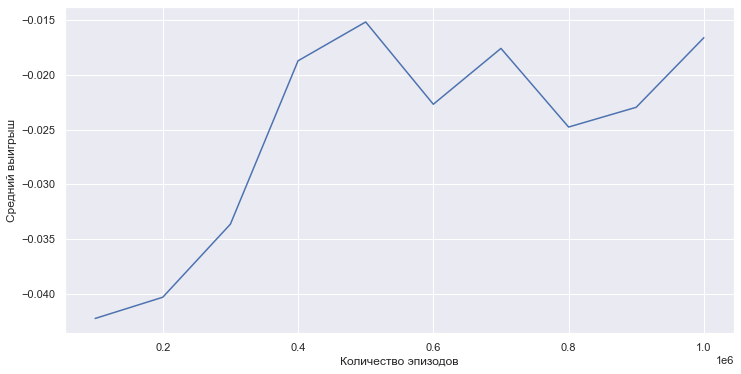

In [1804]:
plt.figure(figsize=(12, 6))
plt.xlabel('Количество эпизодов')
plt.ylabel('Средний выигрыш')
plt.plot(range(n_of_episodes // rec_freq, n_of_episodes + 1, n_of_episodes // rec_freq), learning_history_MC)
plt.show()

Рассмотрим результаты реализации стратегии, обученной **методом Q-обучения**

In [1674]:
%%time
env_double = BlackjackDoubleEnv(natural=True)
n_of_episodes = 1000000
gamma = 1
eps = 0.1
alpha = 0.05
estim_epsds = 100000
rec_freq = 10

learning_history_Q = []
Q_opt = Q_learning(env_double, gamma, n_of_episodes, eps, alpha, rec_history=True, estim_epsds=estim_epsds, rec_freq=rec_freq)
pi_opt = compute_policy_by_Q(Q_opt)
avg_payoff_opt = average_payoff(env_double, pi_opt, estim_epsds)

env_double.close()

Wall time: 2min 26s


Оценка выигрыша стратегии $\pi^*$:

In [1682]:
print(f'Таким образом на {estim_epsds} раздачах получаем по нашей стратегии средний выигрыш {avg_payoff_opt}')

Таким образом на 100000 раздачах получаем по нашей стратегии средний выигрыш -0.03398


Нарисуем график обучения данной стратегии по среднему доходу

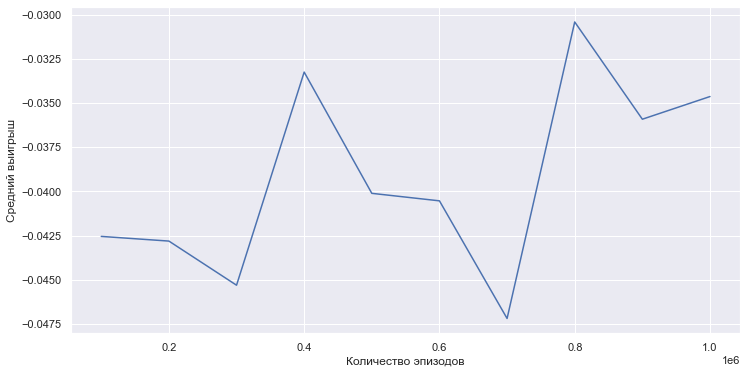

In [1677]:
plt.figure(figsize=(12, 6))
plt.xlabel('Количество эпизодов')
plt.ylabel('Средний выигрыш')
plt.plot(range(n_of_episodes // rec_freq, n_of_episodes + 1, n_of_episodes // rec_freq), learning_history_Q)
plt.show()

### Часть третья, в главной роли — Дастин Хоффман

##### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).

Реализуем систему подсчета "Половинки" (*Wong Halves system*)

In [1794]:
import gym
from gym import spaces
from gym.utils import seeding


MIN_CARDS_NUMBER = 15

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
cards_values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]

cards_ranks = {
    2: 0.5, 
    3: 1., 
    4: 1., 
    5: 1.5, 
    6: 1., 
    7: 0.5, 
    8: 0., 
    9: -0.5, 
    10: -1., 
    1: -1.}  # halves strategy

MAX_COUNT = sum(filter(lambda x: x > 0, map(cards_ranks.get, cards_values))) * 4

MIN_COUNT = sum(filter(lambda x: x < 0, map(cards_ranks.get, cards_values))) * 4


def cmp(a, b):
    return float(a > b) - float(a < b)


def usable_ace(hand):  # Does this hand have a usable ace?
    return 1 in hand and sum(hand) + 10 <= 21


def sum_hand(hand):  # Return current hand total
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)


def is_bust(hand):  # Is this hand a bust?
    return sum_hand(hand) > 21


def score(hand):  # What is the score of this hand (0 if bust)
    return 0 if is_bust(hand) else sum_hand(hand)


def is_natural(hand):  # Is this hand a natural blackjack?
    return sorted(hand) == [1, 10]


class BlackjackCountEnv(gym.Env):
    def __init__(self, natural=False):
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(2*(MAX_COUNT-MIN_COUNT) + 1)))
        self.seed()
        
        self.deck = cards_values * 4
        self.card_count = 0.

        # Flag to payout 1.5 on a "natural" blackjack win, like casino rules
        # Ref: http://www.bicyclecards.com/how-to-play/blackjack/
        self.natural = natural
        # Start the first game
        # self.reset()

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def draw_card(self, np_random):
        card = int(np_random.choice(self.deck))
        self.deck.remove(card)
        self.card_count += cards_ranks[card]
        return card

    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            self.player.append(self.draw_card(self.np_random))
            if is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        else:  # stick or double
            done = True
            if action == 2:  # double
                self.player.append(self.draw_card(self.np_random))
                if is_bust(self.player):
                    reward = -2.
                    return self._get_obs(), reward, done, {}
            while sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card(self.np_random))
            reward = cmp(score(self.player), score(self.dealer))
            if action == 2:
                reward *= 2
            if self.natural and is_natural(self.player) and reward == 1.:
                reward = 1.5
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (sum_hand(self.player), self.dealer[0], usable_ace(self.player), self.card_count)

    def reset(self):
        if len(self.deck) < MIN_CARDS_NUMBER:
            self.deck = cards_values * 4
            self.card_count = 0.
        self.dealer = [self.draw_card(self.np_random)]
        self.player = [self.draw_card(self.np_random), self.draw_card(self.np_random)]
        return self._get_obs()

##### 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2

Здесь у нас уже на 2 порядка больше состояний, так что обучать, конечно, нужно намного дольше.

Рассмотрим результаты реализации стратегии, обученной **методом Монте-Карло**

In [1810]:
%%time
env_count = BlackjackCountEnv(natural=True)
n_of_episodes = 5000000
gamma = 1
eps = 0.1
estim_epsds = 100000
rec_freq = 10

learning_history_MC = []
Q_opt = monte_carlo_control(env_count, gamma, n_of_episodes, eps, rec_history=True, estim_epsds=estim_epsds, rec_freq=rec_freq)
pi_opt = compute_policy_by_Q(Q_opt)
avg_payoff_opt = average_payoff(env_count, pi_opt, estim_epsds)

env_count.close()

Wall time: 11min 36s


Оценка выигрыша стратегии $\pi^*$:

In [1821]:
print(f'Таким образом на {estim_epsds} раздачах получаем по нашей стратегии средний выигрыш {avg_payoff_opt}')

Таким образом на 100000 раздачах получаем по нашей стратегии средний выигрыш -0.017455


Нарисуем график обучения данной стратегии по среднему доходу

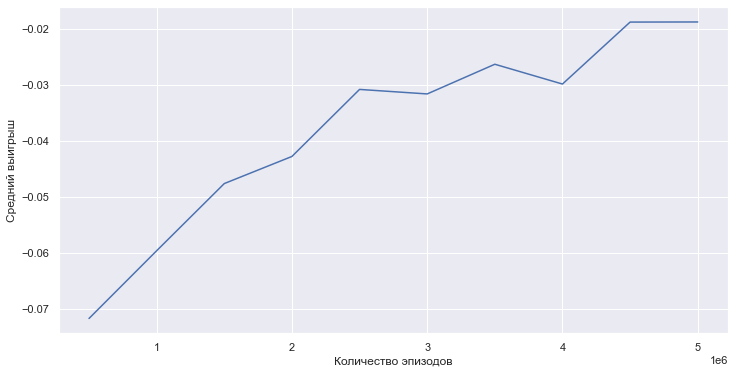

In [1822]:
plt.figure(figsize=(12, 6))
plt.xlabel('Количество эпизодов')
plt.ylabel('Средний выигрыш')
plt.plot(range(n_of_episodes // rec_freq, n_of_episodes + 1, n_of_episodes // rec_freq), learning_history_MC)
plt.show()

Видим, что стоит обучить на еще большем числе эпизодов.

Рассмотрим результаты реализации стратегии, обученной **методом Q-обучения**.

In [1684]:
%%time
env_count = BlackjackCountEnv(natural=True)
n_of_episodes = 5000000
gamma = 0.2
eps = 0.1
alpha = 0.05
estim_epsds = 100000
rec_freq = 10

learning_history_Q = []
Q_opt = Q_learning(env_count, gamma, n_of_episodes, eps, alpha, rec_history=True, estim_epsds=estim_epsds, rec_freq=rec_freq)
pi_opt = compute_policy_by_Q(Q_opt)
avg_payoff_opt = average_payoff(env_count, pi_opt, estim_epsds)

env_count.close()

Wall time: 8min 47s


Оценка выигрыша стратегии $\pi^*$:

In [1686]:
print(f'Таким образом на {estim_epsds} раздачах получаем по нашей стратегии средний выигрыш {avg_payoff_opt}')

Таким образом на 100000 раздачах получаем по нашей стратегии средний выигрыш -0.02133


Нарисуем график обучения данной стратегии по среднему доходу

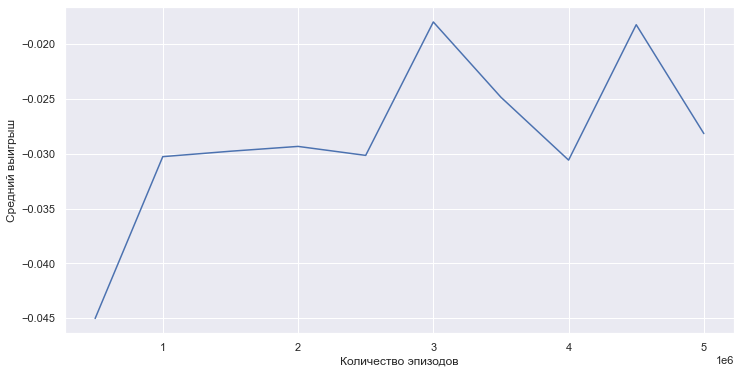

In [1687]:
plt.figure(figsize=(12, 6))
plt.xlabel('Количество эпизодов')
plt.ylabel('Средний выигрыш')
plt.plot(range(n_of_episodes // rec_freq, n_of_episodes + 1, n_of_episodes // rec_freq), learning_history_Q)
plt.show()